In [75]:
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Select, HoverTool
from bokeh.io import show, output_notebook
from bokeh.transform import factor_cmap
from bokeh.layouts import row, column
from bokeh.models import FactorRange
from colorcet import glasbey
import plotly_express as px
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
import statsmodels.api as sm
import seaborn as sns
import sys
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup as BS
import re
from urllib.request import Request, urlopen
import warnings
warnings.filterwarnings('ignore')

In [46]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

        
# <center> Blue Barrcudas: Webscraping OpenSecrets</center>   


<img src="download.jfif" style="display:block; margin:auto">

# <center>Christopher Harrelson, Neda Taherkhani, Jessica Ra</center>





In [77]:
all_districts = pd.read_csv("Write_Data_Here_all_districts.csv")
all_districts.Winner = pd.get_dummies(all_districts.Winner, drop_first = True)

party_dim = go.parcats.Dimension(
    values = all_districts.Party,
    categoryorder = 'category ascending', 
    label = 'Party'
)

incum_dim = go.parcats.Dimension(values = all_districts.Incumbent, 
                                 label = 'Incumbent')

winner_dim = go.parcats.Dimension(values = all_districts.Winner, 
                                  label = 'Outcome',
                                  categoryarray = [1, 0],
                                  ticktext = ['Won', 'Lost']
)

# Create parcats trace
color = all_districts.Winner
colorscale = 'Earth'
fig = go.Figure(data = [go.Parcats(dimensions = [party_dim, incum_dim, winner_dim],
                                   line = {'color': color, 
                                           'colorscale': colorscale},
                                   hoveron = 'color', 
                                   hoverinfo = 'count+probability',
                                   labelfont = {'size': 18, 'family': 'Times'},
                                   tickfont = {'size': 16, 'family': 'Times'},
                                   arrangement = 'freeform')])
fig.show()

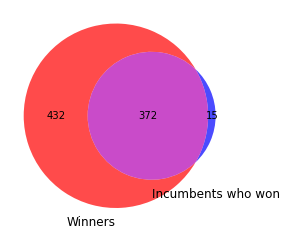

In [63]:
from matplotlib_venn import venn2 
from matplotlib import pyplot as plt
  
# depict venn diagram
venn2(subsets = (432, 15, 372), set_labels = ('Winners', 'Incumbents who won'),
set_colors=("red","blue"),alpha=0.7)
plt.show()

In [57]:
all_districts = pd.read_csv("Write_Data_Here_all_districts.csv").drop(648)
fig = px.treemap(all_districts, path=[px.Constant("US"), 'State','District', 'Name'],
                 values= 'Raised', color='Raised')
fig.show()

In [64]:
#fig = px.bar(All_states.nlargest(10,'Raised'), x="Candidate", y="Raised", color='Raised',
             #height=400,
             #title='Restaurant bills')
fig = px.bar(all_districts.nlargest(25,'Raised'), x="Name", y="Raised", color='Raised',
             height=400,
             title='Top 25 House Candidates Who Raised Most in 2019-2020')
fig.add_hline(y=1859820.19,line_width=3,line_dash='dot',line_color="black",
              annotation_text="Avg. amount raised for ALL candidates", 
              annotation_position="bottom right", 
              annotation_font_size=10,
              annotation_font_color="black",
             )

fig.update_xaxes(tickangle=45, tickfont=dict(family='Arial', color='Black', size=10))

fig.show()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


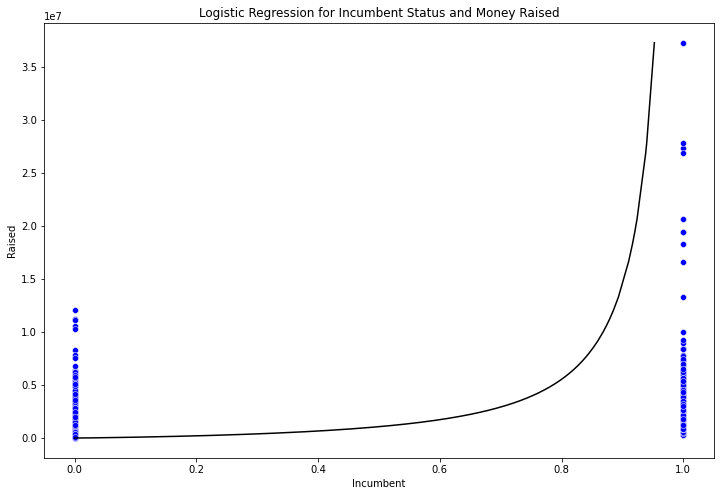

In [76]:
# Question 4(e)
# Run a logistic regression on incumbency vs. money raised, but plot inversely.
all_districts['Incumbent'] = pd.get_dummies(all_districts['Incumbent'], drop_first = True)
all_districts = all_districts.loc[all_districts['Raised'] > 0]

x_values = sm.add_constant(np.log(all_districts['Raised']))
incumbent_model = sm.Logit(endog = all_districts['Incumbent'], exog = x_values).fit()
all_districts['Predicted Values'] = incumbent_model.predict(x_values)

fig, ax = plt.subplots(figsize = (12, 8))
sns.scatterplot('Incumbent', 'Raised', data = all_districts, color = 'blue', ax = ax);
sns.lineplot('Predicted Values', 'Raised', data = all_districts, color = 'black', ax = ax);
plt.xlim(-0.05,1.05)
plt.title('Logistic Regression for Incumbent Status and Money Raised');

In [41]:
def bkapp(doc):
    """Function to produce vbar plot in Bokeh inline in Jupyter notebook."""
    top_twenty_sources = pd.read_csv("Write_Data_Here_top_twenty_sources.csv").dropna()
    # Create ColumnDataSource.
    source = ColumnDataSource(top_twenty_sources[top_twenty_sources['Name'] == 'Bernie Sanders'])
    # Create hovertool.
    hover = HoverTool(tooltips = [("Contributor", "@Contributor"),
                                  ("Total", "@Total")], 
                      mode = 'vline')
    
    # Create figure for vbars. x_range must be set to initial value.
    top_twenty_plot = (
        figure(title = 'Top Contributors to Bernie Sanders',
               x_range = FactorRange(factors = top_twenty_sources['Contributor'].\
                                     loc[top_twenty_sources['Name'] == 'Bernie Sanders'].tolist()),
               x_axis_label = 'Contributor',
               y_axis_label = 'Total', 
               width = 650)
    )
    
    # Create actual vbars and color map.
    top_twenty_plot_two = top_twenty_plot.vbar(x = 'Contributor', 
                                               top = 'Total', 
                                               width = 0.9, 
                                               source = source, 
                                               fill_color = factor_cmap('Contributor', 
                                                                        palette = glasbey, 
                                                                        factors = top_twenty_plot.x_range.factors))
    # Add hovertool to plot.
    top_twenty_plot.add_tools(hover)
    
    
    def select1_change(attrname, old, new):
        """Function to update second dropdown options based on first dropdown selection."""
        if select1.value == 'Senator':
            select2.options = (
                top_twenty_sources['Name'].\
                loc[top_twenty_sources['Senator or Representative'] == 'Senator'].\
                unique().\
                tolist())
            select2.value = 'Bernie Sanders'
        else:
                select2.options = top_twenty_sources['Name'].\
                loc[top_twenty_sources['Senator or Representative'] == 'Representative'].\
                unique().\
                tolist()
                select2.value = 'Alexandria Ocasio-Cortez'
    
    def update_plot(attrname, old, new):
        """Function to update plot values and colormap upon change of congressmember name in select bar."""
        source.data = ColumnDataSource.from_df(top_twenty_sources[top_twenty_sources['Name'] == select2.value])
        top_twenty_plot.x_range.factors = (
            top_twenty_sources['Contributor'].loc[top_twenty_sources['Name'] == select2.value].tolist()
        )
        top_twenty_plot_two.glyph.fill_color = factor_cmap('Contributor', 
                                                           palette = glasbey, 
                                                           factors = top_twenty_plot.x_range.factors)
        top_twenty_plot.title.text = 'Top Contributors to %s' % select2.value
    
    # Create dropdown box.
    select1 = Select(title = "Senator or Representative", 
                          value = "Senator",
                          options = ["Senator", "Representative"]) 
    
    select2 = Select(title = "Member of Congress", 
                          value = "Bernie Sanders",
                          options = top_twenty_sources['Name'].unique().tolist())
    
    # Adjust xticks to have room.
    top_twenty_plot.xaxis.major_label_orientation = 1.25
    
    # Change values on change in dropdown box.
    select1.on_change('value', select1_change)
    select2.on_change('value', update_plot)
    
    # Bokeh specific display language.
    layout = row(column(select1, select2), top_twenty_plot)
    doc.add_root(layout)

# Activates widget bar plot of top twenty contributors that updates based on member of congress.

# local host needs to change based on what your computer says.
show(bkapp, notebook_url = "http://localhost:8979")

In [20]:
all_contributions_by_source=pd.read_csv("Write_data_here_all_contributions_by_source.csv")

In [42]:
fig = px.box(all_contributions_by_source, 
             y = "Type of Contribution", 
             x = "Amount", 
             points="outliers",
             hover_name = 'Name',
             color = 'Type of Contribution', 
             orientation = 'h',
             width = 1000)
fig.update_layout(showlegend=False,
                  yaxis = go.layout.YAxis(
                      tickangle = 0, 
                      tickfont = {'size':12},
                      gridcolor = 'white')) 
fig.show()

In [28]:
top_twenty_sources = pd.read_csv("Write_Data_Here_top_twenty_sources.csv")

In [61]:
first_plot = three_d_bar_chart_data.sort_values('Democrat', ascending = False)[:10]
first_plot['Width'] = first_plot['Democrat'].apply(lambda x: x/first_plot['Democrat'].sum()*360)
second_plot = three_d_bar_chart_data.sort_values('Republican', ascending = False)[:10]
second_plot['Width'] = second_plot['Republican'].apply(lambda x: x/second_plot['Republican'].sum()*360)

fig = make_subplots(rows = 1, 
                    cols = 2, 
                    specs=[[{"type": "polar"}, {"type": "polar"}]])

def find_theta(i, series):
    theta = 0
    x = 0
    while x <= list(series).index(i):
        theta += series[x]/2 + series[x-1]/2
        x += 1
    return theta

fig.add_trace(go.Barpolar(name = 'Democrats',
                          theta = [find_theta(i, first_plot['Width']) for i in first_plot['Width']],
                          width = first_plot['Width'],
                          r = first_plot['Democrat'],
                          hoverinfo = 'text + r',
                          text = [k for k in dict(first_plot['Democrat']).keys()]), 
              row = 1, 
              col = 1)

fig.add_trace(go.Barpolar(name = 'Republicans',
                          theta = [find_theta(i, second_plot['Width']) for i in second_plot['Width']],
                          width = second_plot['Width'],
                          r = second_plot['Republican'],
                          hoverinfo = 'text + r',
                          text = [k for k in dict(second_plot['Republican']).keys()]), 
              row = 1, 
              col = 2)

fig.update_layout(height = 600,
                  width = 1000,
                  title_text= "Breakdown of Top Funding Sources by Major Party")

fig.show()

In [78]:
all_contributions_by_source = pd.read_csv("Write_Data_Here_all_contributions_by_source.csv")
top_twenty_sources = pd.read_csv("Write_Data_Here_top_twenty_sources.csv")

IndexError: list index out of range

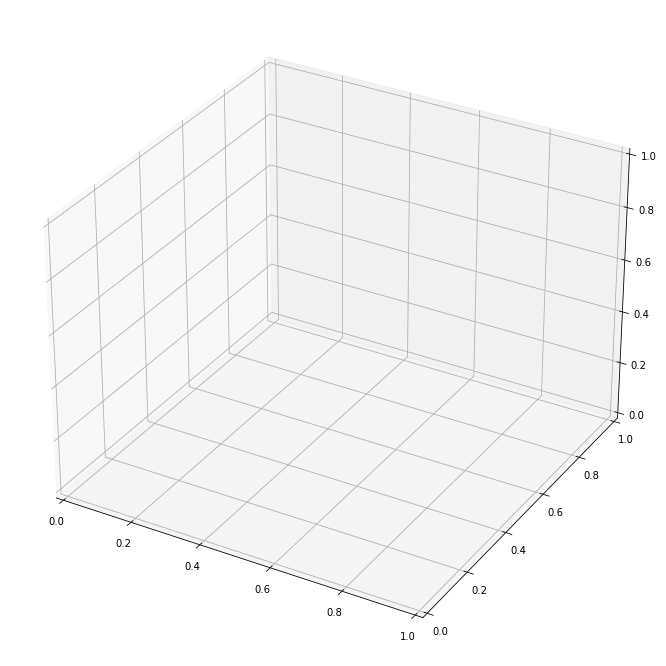

In [79]:
three_d_bar_chart_data = (
    pd.pivot_table(top_twenty_sources.loc[top_twenty_sources['Contributor'].\
                                          isin(top_twenty_sources['Contributor'].\
                                               value_counts().nlargest(10).index.tolist())],
                   values = 'Total', 
                   index = 'Contributor', 
                   columns = 'Party',
                   aggfunc = np.sum).fillna(0).astype('int64')
)

fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(111, projection = '3d')

dz = []
for i in np.arange(0,4,1):
    for j in np.arange(0,10,1):
        dz.append(three_d_bar_chart_data\
                  [three_d_bar_chart_data.columns.tolist()[i]]\
                  [three_d_bar_chart_data.index.tolist()[j]])
np.array(dz).ravel()

x3, y3 = (
    np.meshgrid(np.arange(0,4,1), 
                np.arange(0,10,1))
)
x3, y3 = x3.ravel(), y3.ravel()

dx = 0.5
dy = 0.5
z3 = np.zeros_like(dz)

color_dict = {0:'b', 1:'y', 2:'r', 3:'g'}
colormap = [color_dict[i] for i in x3]

ax1.bar3d(x3, y3, z3, dx, dy, dz, alpha = 0.8, color = colormap, shade = True)

ax1.set_zlabel('Sum of Contribution')

ticksx = np.arange(0,4,1)
plt.xticks(ticksx, three_d_bar_chart_data.columns)

ticksy = np.arange(0,10,1)
plt.yticks(ticksy, ["Nat'l Assn of Realtors",
                    'Comcast',
                    'AT&T',
                    'Am. Bankers Assn',
                    'IBEW',
                    'Northrop Grumman',
                    'BCBS',
                    'Raytheon',
                    'Am. Crystal Sugar',
                    'Home Depot'])
plt.show()